In [1]:
import os
import cv2
import random
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
train_dir = 'data/Training'
test_dir = 'data/Testing'
classes = os.listdir(train_dir)

In [3]:
resize_size = 256
crop_size = 224

def preprocess_image(image):
    image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR) #크기 조절
    image = tf.image.central_crop(image, central_fraction=crop_size / resize_size) #중앙 224x224
    image = tf.math.divide(image, 255.0) #normalize
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std #다 normalize

    return image

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True
)

In [5]:
from sklearn.preprocessing import LabelEncoder

X = [] #Image
y = [] #class
for i in classes:
    for data_dir in [train_dir, test_dir]:
        folderPath = os.path.join(data_dir,i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j)) 
            img = preprocess_image(img)
            X.append(img)
            y.append(i)
X = np.array(X)
y = np.array(y)
y = tf.keras.utils.to_categorical([classes.index(label) for label in y])

  6%|██▌                                        | 24/395 [00:00<00:02, 133.06it/s]

Metal device set to: Apple M2 Pro


100%|████████████████████████████████████████████| 74/74 [00:00<00:00, 149.11it/s]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42) #training 분할 (train,val)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42) #training 분할 (train,val)

In [7]:
train_data = data_gen.flow(x=X_train, y=y_train)

In [26]:
#그래프 그려주는 거 (성능 그래프)
def plot_acc_model(acc, val_acc, epochs):
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

def plot_loss_model(loss, val_loss, epochs):
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, EfficientNetV2L, ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import os
from vit_keras import vit, utils

epochs=100

def create_and_compile_model(base_model, output_size, model_name):
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    output = Dense(output_size, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model_dir = f"aug02_model/{model_name}/"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
    best_model_checkpoint = ModelCheckpoint(f"{model_dir}best_model.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    csv_logger = CSVLogger(f'aug02_model/training_log_{model_name}.csv', separator=',', append=False)
    return model, [early_stopping, best_model_checkpoint,csv_logger]


base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_vgg, callbacks_vgg = create_and_compile_model(base_model_vgg, output_size=4, model_name='vgg')
base_model_efficientnet = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_efficientnet, callbacks_efficientnet = create_and_compile_model(base_model_efficientnet, output_size=4, model_name='eff')
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet, callbacks_resnet = create_and_compile_model(base_model_resnet, output_size=4, model_name='resnet')
base_model_vit = vit.vit_b16(image_size=224, activation='sigmoid', pretrained=True)
model_vit, callbacks_vit = create_and_compile_model(base_model_vit, output_size=4, model_name='vit')

history_vit = model_vit.fit(train_data,
                                  epochs=epochs,
                                  validation_data=(X_val, y_val),
                                  verbose=1,
                                  callbacks=callbacks_vit)

history_vgg = model_vgg.fit(train_data,
                            epochs=epochs,
                            validation_data=(X_val, y_val),
                            verbose=1,
                            callbacks=callbacks_vgg)

history_efficientnet = model_efficientnet.fit(train_data,
                                              epochs=epochs,
                                              validation_data=(X_val, y_val),
                                              verbose=1,
                                              callbacks=callbacks_efficientnet)
history_resnet = model_resnet.fit(train_data,
                                  epochs=epochs,
                                  validation_data=(X_val, y_val),
                                  verbose=1,
                                  callbacks=callbacks_resnet)

/Users/sunyoung-park/miniforge3/envs/tf_gpu/lib/python3.8/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/100
83/83 [==============================] - ETA: 0s - loss: 1.3638 - accuracy: 0.2773
Epoch 1: val_loss improved from inf to 1.32364, saving model to aug02_model/vit/best_model.h5
83/83 [==============================] - 164s 2s/step - loss: 1.3638 - accuracy: 0.2773 - val_loss: 1.3236 - val_accuracy: 0.3231
Epoch 2/100
83/83 [==============================] - ETA: 0s - loss: 1.3393 - accuracy: 0.3034
Epoch 2: val_loss improved from 1.32364 to 1.30540, saving model to aug02_model/vit/best_model.h5
83/83 [==============================] - 112s 1s/step - loss: 1.3393 - accuracy: 0.3034 - val_loss: 1.3054 - val_accuracy: 0.3741
Epoch 3/100
83/83 [==============================] - ETA: 0s - loss: 1.3213 - accuracy: 0.3140
Epoch 3: val_loss improved from 1.30540 to 1.29023, saving model to aug02_model/vit/best_model.h5
83/83 [==============================] - 113s 1s/step - loss: 1.3213 - accuracy: 0.3140 - val_loss: 1.2902 - val_accuracy: 0.3844
Epoch 4/100
83/83 [================

83/83 [==============================] - 118s 1s/step - loss: 1.1079 - accuracy: 0.5547 - val_loss: 1.0910 - val_accuracy: 0.5748
Epoch 27/100
83/83 [==============================] - ETA: 0s - loss: 1.0976 - accuracy: 0.5672
Epoch 27: val_loss did not improve from 1.09102
83/83 [==============================] - 115s 1s/step - loss: 1.0976 - accuracy: 0.5672 - val_loss: 1.0913 - val_accuracy: 0.5510
Epoch 28/100
83/83 [==============================] - ETA: 0s - loss: 1.0995 - accuracy: 0.5675
Epoch 28: val_loss improved from 1.09102 to 1.07831, saving model to aug02_model/vit/best_model.h5
83/83 [==============================] - 113s 1s/step - loss: 1.0995 - accuracy: 0.5675 - val_loss: 1.0783 - val_accuracy: 0.5884
Epoch 29/100
83/83 [==============================] - ETA: 0s - loss: 1.0886 - accuracy: 0.5728
Epoch 29: val_loss improved from 1.07831 to 1.06306, saving model to aug02_model/vit/best_model.h5
83/83 [==============================] - 118s 1s/step - loss: 1.0886 - accur

Epoch 81/100
83/83 [==============================] - ETA: 0s - loss: 0.9069 - accuracy: 0.6716
Epoch 81: val_loss improved from 0.91846 to 0.91666, saving model to aug02_model/vit/best_model.h5
83/83 [==============================] - 110s 1s/step - loss: 0.9069 - accuracy: 0.6716 - val_loss: 0.9167 - val_accuracy: 0.6190
Epoch 82/100
83/83 [==============================] - ETA: 0s - loss: 0.9064 - accuracy: 0.6667
Epoch 82: val_loss did not improve from 0.91666
83/83 [==============================] - 153s 2s/step - loss: 0.9064 - accuracy: 0.6667 - val_loss: 0.9207 - val_accuracy: 0.6088
Epoch 83/100
83/83 [==============================] - ETA: 0s - loss: 0.9035 - accuracy: 0.6833
Epoch 83: val_loss improved from 0.91666 to 0.91128, saving model to aug02_model/vit/best_model.h5
83/83 [==============================] - 175s 2s/step - loss: 0.9035 - accuracy: 0.6833 - val_loss: 0.9113 - val_accuracy: 0.6156
Epoch 84/100
83/83 [==============================] - ETA: 0s - loss: 0.8990

83/83 [==============================] - 47s 565ms/step - loss: 0.5838 - accuracy: 0.7934 - val_loss: 0.6240 - val_accuracy: 0.7619
Epoch 8/100
83/83 [==============================] - ETA: 0s - loss: 0.5498 - accuracy: 0.8059
Epoch 8: val_loss did not improve from 0.62396
83/83 [==============================] - 36s 424ms/step - loss: 0.5498 - accuracy: 0.8059 - val_loss: 0.6670 - val_accuracy: 0.7347
Epoch 9/100
83/83 [==============================] - ETA: 0s - loss: 0.5250 - accuracy: 0.8241
Epoch 9: val_loss improved from 0.62396 to 0.57154, saving model to aug02_model/vgg/best_model.h5
83/83 [==============================] - 33s 398ms/step - loss: 0.5250 - accuracy: 0.8241 - val_loss: 0.5715 - val_accuracy: 0.7959
Epoch 10/100
83/83 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.8165
Epoch 10: val_loss improved from 0.57154 to 0.55833, saving model to aug02_model/vgg/best_model.h5
83/83 [==============================] - 36s 414ms/step - loss: 0.5242 - a

83/83 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.8793
Epoch 35: val_loss did not improve from 0.41803
83/83 [==============================] - 32s 386ms/step - loss: 0.3498 - accuracy: 0.8793 - val_loss: 0.4245 - val_accuracy: 0.8163
Epoch 36/100
83/83 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8770
Epoch 36: val_loss did not improve from 0.41803
83/83 [==============================] - 32s 386ms/step - loss: 0.3480 - accuracy: 0.8770 - val_loss: 0.4729 - val_accuracy: 0.8265
Epoch 37/100
83/83 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8797
Epoch 37: val_loss did not improve from 0.41803
83/83 [==============================] - 31s 377ms/step - loss: 0.3480 - accuracy: 0.8797 - val_loss: 0.4263 - val_accuracy: 0.8095
Epoch 38/100
83/83 [==============================] - ETA: 0s - loss: 0.3376 - accuracy: 0.8801
Epoch 38: val_loss improved from 0.41803 to 0.40977, saving model to aug02_model/vgg/best

Epoch 91/100
83/83 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9258
Epoch 91: val_loss did not improve from 0.31946
83/83 [==============================] - 44s 517ms/step - loss: 0.2341 - accuracy: 0.9258 - val_loss: 0.3440 - val_accuracy: 0.8503
Epoch 92/100
83/83 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9258
Epoch 92: val_loss did not improve from 0.31946
83/83 [==============================] - 43s 512ms/step - loss: 0.2369 - accuracy: 0.9258 - val_loss: 0.3198 - val_accuracy: 0.8878
Epoch 93/100
83/83 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9292
Epoch 93: val_loss did not improve from 0.31946
83/83 [==============================] - 37s 445ms/step - loss: 0.2367 - accuracy: 0.9292 - val_loss: 0.3207 - val_accuracy: 0.8844
Epoch 94/100
83/83 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9327
Epoch 94: val_loss did not improve from 0.31946
83/83 [=====================

Epoch 20/100
83/83 [==============================] - ETA: 0s - loss: 12.9765 - accuracy: 0.3666
Epoch 20: val_loss did not improve from 11.78115
83/83 [==============================] - 99s 1s/step - loss: 12.9765 - accuracy: 0.3666 - val_loss: 15.6122 - val_accuracy: 0.3503
Epoch 21/100
83/83 [==============================] - ETA: 0s - loss: 16.5994 - accuracy: 0.3386
Epoch 21: val_loss did not improve from 11.78115
83/83 [==============================] - 107s 1s/step - loss: 16.5994 - accuracy: 0.3386 - val_loss: 21.9964 - val_accuracy: 0.3027
Epoch 22/100
83/83 [==============================] - ETA: 0s - loss: 14.6055 - accuracy: 0.3462
Epoch 22: val_loss did not improve from 11.78115
83/83 [==============================] - 107s 1s/step - loss: 14.6055 - accuracy: 0.3462 - val_loss: 22.7437 - val_accuracy: 0.3027
Epoch 23/100
83/83 [==============================] - ETA: 0s - loss: 13.0403 - accuracy: 0.3833
Epoch 23: val_loss did not improve from 11.78115
83/83 [==============

Epoch 79/100
83/83 [==============================] - ETA: 0s - loss: 10.1812 - accuracy: 0.4525
Epoch 79: val_loss did not improve from 3.13952
83/83 [==============================] - 105s 1s/step - loss: 10.1812 - accuracy: 0.4525 - val_loss: 7.4885 - val_accuracy: 0.3878
Epoch 80/100
83/83 [==============================] - ETA: 0s - loss: 9.4865 - accuracy: 0.4642
Epoch 80: val_loss did not improve from 3.13952
83/83 [==============================] - 106s 1s/step - loss: 9.4865 - accuracy: 0.4642 - val_loss: 11.3272 - val_accuracy: 0.4150
Epoch 81/100
83/83 [==============================] - ETA: 0s - loss: 9.9552 - accuracy: 0.4518
Epoch 81: val_loss did not improve from 3.13952
83/83 [==============================] - 108s 1s/step - loss: 9.9552 - accuracy: 0.4518 - val_loss: 10.1714 - val_accuracy: 0.4286
Epoch 82/100
83/83 [==============================] - ETA: 0s - loss: 10.4985 - accuracy: 0.4378
Epoch 82: val_loss did not improve from 3.13952
83/83 [======================

Epoch 37/100
83/83 [==============================] - ETA: 0s - loss: 1.9996 - accuracy: 0.7631
Epoch 37: val_loss did not improve from 0.99902
83/83 [==============================] - 17s 209ms/step - loss: 1.9996 - accuracy: 0.7631 - val_loss: 4.1334 - val_accuracy: 0.6565
Epoch 38/100
83/83 [==============================] - ETA: 0s - loss: 1.6771 - accuracy: 0.7628
Epoch 38: val_loss did not improve from 0.99902
83/83 [==============================] - 17s 209ms/step - loss: 1.6771 - accuracy: 0.7628 - val_loss: 1.3077 - val_accuracy: 0.7959
Epoch 39/100
83/83 [==============================] - ETA: 0s - loss: 1.2421 - accuracy: 0.8033
Epoch 39: val_loss did not improve from 0.99902
83/83 [==============================] - 18s 212ms/step - loss: 1.2421 - accuracy: 0.8033 - val_loss: 2.3213 - val_accuracy: 0.6803
Epoch 40/100
83/83 [==============================] - ETA: 0s - loss: 1.1267 - accuracy: 0.8029
Epoch 40: val_loss did not improve from 0.99902
83/83 [=====================

Epoch 96/100
83/83 [==============================] - ETA: 0s - loss: 1.0194 - accuracy: 0.8547
Epoch 96: val_loss did not improve from 0.58295
83/83 [==============================] - 18s 211ms/step - loss: 1.0194 - accuracy: 0.8547 - val_loss: 0.8658 - val_accuracy: 0.8435
Epoch 97/100
83/83 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.8759
Epoch 97: val_loss did not improve from 0.58295
83/83 [==============================] - 18s 214ms/step - loss: 0.6557 - accuracy: 0.8759 - val_loss: 0.6562 - val_accuracy: 0.8537
Epoch 98/100
83/83 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.8642
Epoch 98: val_loss did not improve from 0.58295
83/83 [==============================] - 18s 210ms/step - loss: 0.7830 - accuracy: 0.8642 - val_loss: 2.7535 - val_accuracy: 0.7075
Epoch 99/100
83/83 [==============================] - ETA: 0s - loss: 0.8312 - accuracy: 0.8434
Epoch 99: val_loss did not improve from 0.58295
83/83 [=====================

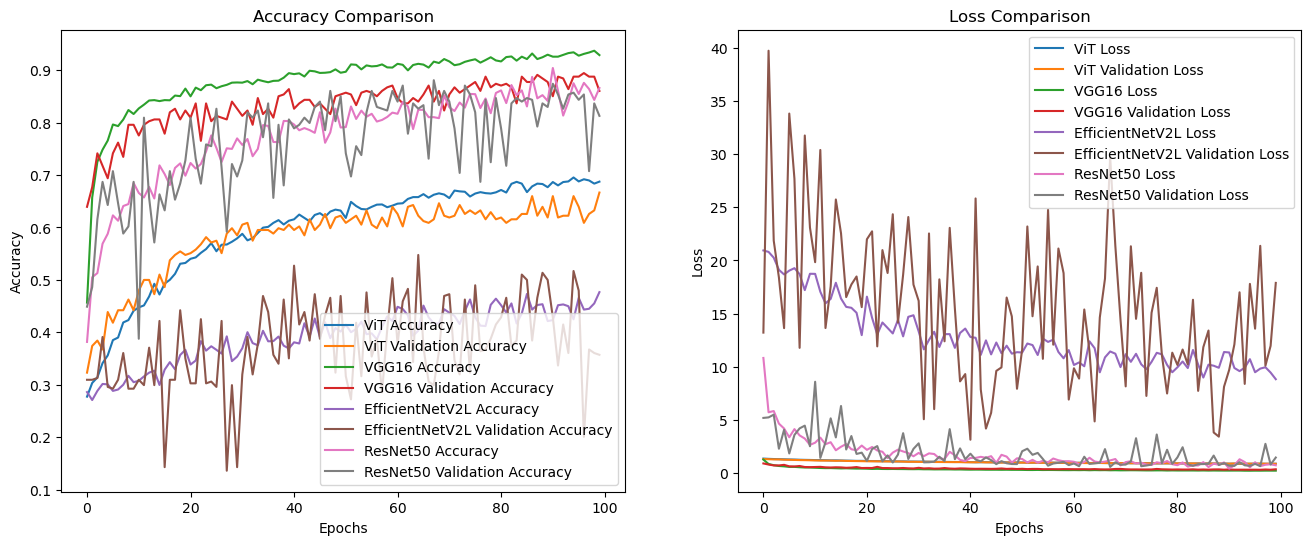

In [27]:
import matplotlib.pyplot as plt

# Function to plot metrics for each model
def plot_metrics(ax, histories, model_names, metric_name):
    for history, model_name in zip(histories, model_names):
        ax.plot(history.history[metric_name], label=f'{model_name} {metric_name.capitalize()}')
        ax.plot(history.history[f'val_{metric_name}'], label=f'{model_name} Validation {metric_name.capitalize()}')

    ax.set_title(f'{metric_name.capitalize()} Comparison')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name.capitalize())
    ax.legend()

# Create a list of model histories and names
model_histories = [history_vit, history_vgg, history_efficientnet, history_resnet]
model_names = ['ViT', 'VGG16', 'EfficientNetV2L', 'ResNet50']

# Create subplots for accuracy
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting training and validation accuracy for each model
plot_metrics(axs[0], model_histories, model_names, 'accuracy')

# Plotting training and validation loss for each model
plot_metrics(axs[1], model_histories, model_names, 'loss')

plt.show()

In [28]:
from sklearn.metrics import classification_report,accuracy_score


for model_name in ["eff", "resnet", "vgg", "vit"]:
    best_model = keras.models.load_model("aug02_model/"+model_name+"/best_model.h5")
    y_pred = best_model.predict(X_test)
    y_pred_single_label = np.argmax(y_pred, axis=1)
    y_test_single_label = np.argmax(y_test, axis=1)
    from sklearn.metrics import classification_report,accuracy_score
    class_report = classification_report(y_test_single_label, y_pred_single_label, zero_division=1)
    print(str(model_name))
    print(class_report)

11/11 [==============================] - 32s 2s/step
eff
              precision    recall  f1-score   support

           0       0.89      0.33      0.49        75
           1       0.50      0.24      0.32        80
           2       0.48      0.47      0.47        85
           3       0.46      0.93      0.61        87

    accuracy                           0.50       327
   macro avg       0.58      0.49      0.47       327
weighted avg       0.57      0.50      0.48       327

11/11 [==============================] - 8s 266ms/step
resnet
              precision    recall  f1-score   support

           0       0.98      0.87      0.92        75
           1       0.75      0.81      0.78        80
           2       0.80      0.82      0.81        85
           3       0.92      0.92      0.92        87

    accuracy                           0.86       327
   macro avg       0.86      0.86      0.86       327
weighted avg       0.86      0.86      0.86       327

11/11 [====

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics for each model
def plot_metrics(ax, histories, model_names, metric_name, train=True, val=True):
    for history, model_name in zip(histories, model_names):
        if train:
            ax.plot(history.history[metric_name], label=f'{model_name} Training {metric_name.capitalize()}')
        if val:
            ax.plot(history.history[f'val_{metric_name}'], label=f'{model_name} Validation {metric_name.capitalize()}')

    ax.set_title(f'{metric_name.capitalize()} Comparison')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name.capitalize())
    ax.legend()

model_histories = [history_vit, history_vgg, history_efficientnet, history_resnet]
model_names = ['ViT', 'VGG16', 'EfficientNetV2L', 'ResNet50']
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plot_metrics(axs[0, 0], model_histories, model_names, 'accuracy', train=True, val=False)
plot_metrics(axs[0, 1], model_histories, model_names, 'accuracy', train=False, val=True)
plot_metrics(axs[1, 0], model_histories, model_names, 'loss', train=True, val=False)
plot_metrics(axs[1, 1], model_histories, model_names, 'loss', train=False, val=True)

plt.show()

In [ ]:
from lime.lime_image import LimeImageExplainer
import matplotlib.pyplot as plt
import shap
from skimage.segmentation import mark_boundaries

best_model = keras.models.load_model("aug01_model/"+model_name+"/best_model.h5")
explainer = LimeImageExplainer()
image_to_explain = X_test[0]
explanation = explainer.explain_instance(X_test[0].astype('double'), best_model.predict, top_labels=1, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
shap.initjs()
masker = shap.maskers.Image(explanation.top_labels[0], X_test[0].shape)
explainer = shap.Explainer(best_model, masker, output_names=classes)
explainer
shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])
shap_values.shape
shap.image_plot(shap_values)